In [ ]:
!unzip out_train.zip

Archive:  out_train.zip
   creating: out_train/
  inflating: out_train/output-slice000.jpg  
  inflating: out_train/output-slice001.jpg  
  inflating: out_train/output-slice002.jpg  
  inflating: out_train/output-slice003.jpg  
  inflating: out_train/output-slice004.jpg  
  inflating: out_train/output-slice005.jpg  
  inflating: out_train/output-slice006.jpg  
  inflating: out_train/output-slice007.jpg  
  inflating: out_train/output-slice008.jpg  
  inflating: out_train/output-slice009.jpg  
  inflating: out_train/output-slice010.jpg  
  inflating: out_train/output-slice011.jpg  
  inflating: out_train/output-slice012.jpg  
  inflating: out_train/output-slice013.jpg  
  inflating: out_train/output-slice014.jpg  
  inflating: out_train/output-slice015.jpg  
  inflating: out_train/output-slice016.jpg  
  inflating: out_train/output-slice017.jpg  
  inflating: out_train/output-slice018.jpg  
  inflating: out_train/output-slice019.jpg  
  inflating: out_train/output-slice020.jpg  
  infla

In [ ]:
!unzip out_train_mask.zip

Archive:  out_train_mask.zip
   creating: out_train_mask/
  inflating: out_train_mask/output-slice000.jpg  
  inflating: out_train_mask/output-slice001.jpg  
  inflating: out_train_mask/output-slice002.jpg  
  inflating: out_train_mask/output-slice003.jpg  
  inflating: out_train_mask/output-slice004.jpg  
  inflating: out_train_mask/output-slice005.jpg  
  inflating: out_train_mask/output-slice006.jpg  
  inflating: out_train_mask/output-slice007.jpg  
  inflating: out_train_mask/output-slice008.jpg  
  inflating: out_train_mask/output-slice009.jpg  
  inflating: out_train_mask/output-slice010.jpg  
  inflating: out_train_mask/output-slice011.jpg  
  inflating: out_train_mask/output-slice012.jpg  
  inflating: out_train_mask/output-slice013.jpg  
  inflating: out_train_mask/output-slice014.jpg  
  inflating: out_train_mask/output-slice015.jpg  
  inflating: out_train_mask/output-slice016.jpg  
  inflating: out_train_mask/output-slice017.jpg  
  inflating: out_train_mask/output-slice01

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
# Set some parameters
im_width = 512
im_height = 512
border = 5

In [ ]:
ids = next(os.walk("out_train"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  100


In [ ]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [ ]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("out_train/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("out_train_mask/"+id_, grayscale=True))
    mask = resize(mask, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
y_train[2].max()

1.0

In [ ]:
has_mask

False

Text(0.5, 1.0, 'Mask')

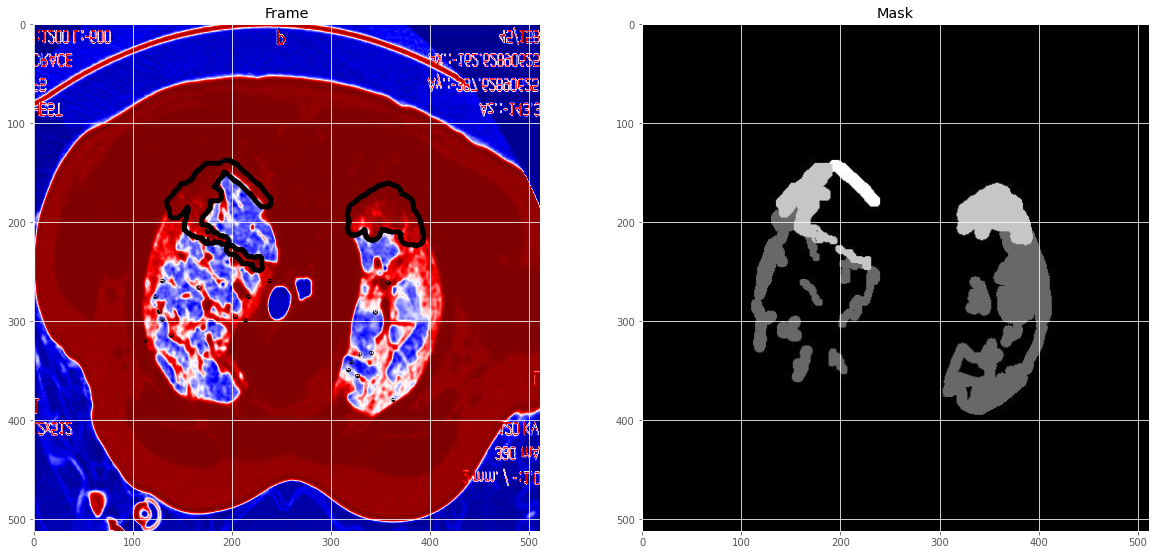

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[2].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[2, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[2].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Frame')

ax2.imshow(y_train[2].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=4, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.6214
Epoch 00001: val_loss improved from inf to 25.27019, saving model to model-tgs-salt.h5
23/23 [==============================] - 8s 346ms/step - loss: 0.6923 - accuracy: 0.6214 - val_loss: 25.2702 - val_accuracy: 0.1470
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 0.4252 - accuracy: 0.8765
Epoch 00002: val_loss improved from 25.27019 to 0.63606, saving model to model-tgs-salt.h5
23/23 [==============================] - 5s 238ms/step - loss: 0.4252 - accuracy: 0.8765 - val_loss: 0.6361 - val_accuracy: 0.6975
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 0.3619 - accuracy: 0.9113
Epoch 00003: val_loss improved from 0.63606 to 0.40252, saving model to model-tgs-salt.h5
23/23 [==============================] - 5s 238ms/step - loss: 0.3619 - accuracy: 0.9113 - val_loss: 0.4025 - val_accuracy: 0.8960
Epoch 4/50
23/23 [==============================] - ETA:

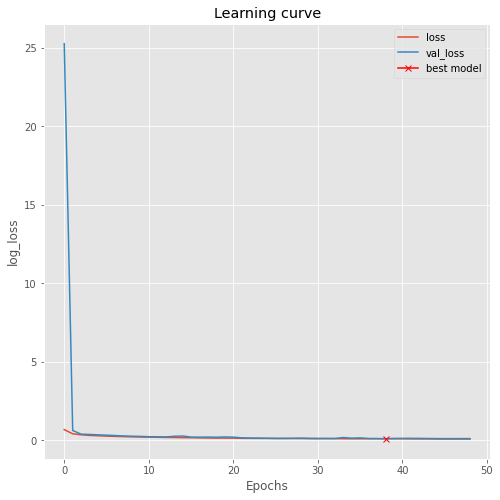

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [ ]:
X_valid.shape

(10, 512, 512, 1)

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 4ms/step - loss: 0.1159 - accuracy: 0.9049


[0.11588982492685318, 0.9049125909805298]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1/1 [==============================] - 0s 161ms/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Frame')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Mask Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Mask Predicted binary');

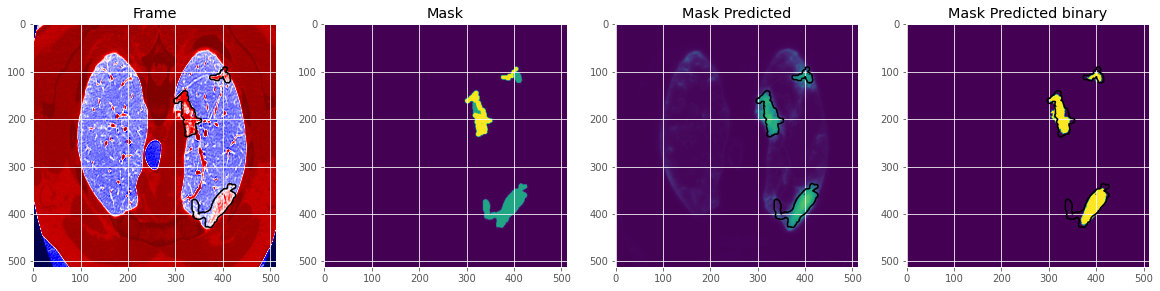

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=21)

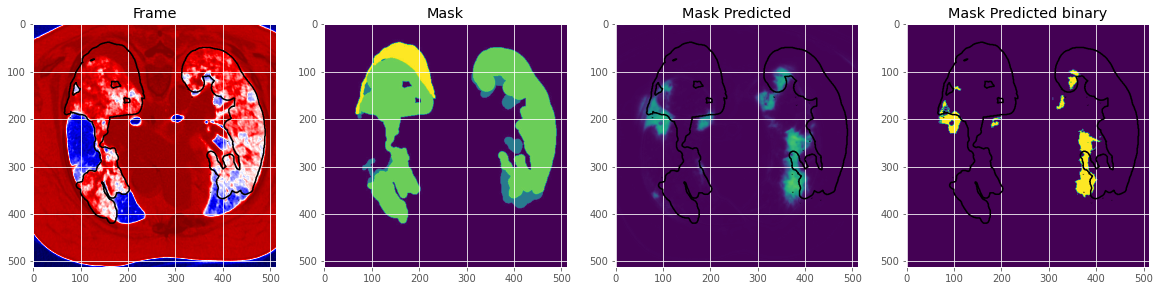

In [ ]:
plot_sample(X_valid, y_valid, preds_train, preds_train_t, ix=3)